# Probability and Statistics

概率统计

In [1]:
import mxnet as mx
from mxnet import nd
mx.random.seed(1)

In [2]:
probabilities = nd.ones(6)/6
nd.sample_multinomial(probabilities)


[3]
<NDArray 1 @cpu(0)>

In [3]:
print(nd.sample_multinomial(probabilities, shape=(10,)))
print(nd.sample_multinomial(probabilities, shape=(5, 10)))


[0 0 3 1 4 4 5 3 0 0]
<NDArray 10 @cpu(0)>

[[2 2 2 4 2 4 4 2 3 5]
 [4 0 0 1 1 0 2 3 0 0]
 [0 2 4 5 2 0 4 3 2 1]
 [1 5 3 0 1 0 5 4 0 1]
 [0 2 1 1 5 4 0 2 1 5]]
<NDArray 5x10 @cpu(0)>


求1000次sample中每个类别出现的概率

In [4]:
rolls = nd.sample_multinomial(probabilities, shape=(1000))

counts = nd.zeros(shape=(6,1000))
totals = nd.zeros(6)
for i, roll in enumerate(rolls):
    totals[int(roll.asscalar())] += 1
    counts[:, i] = totals

In [5]:
totals / 1000


[ 0.17299999  0.182       0.16        0.167       0.147       0.171     ]
<NDArray 6 @cpu(0)>

In [6]:
counts


[[   0.    0.    0. ...,  173.  173.  173.]
 [   0.    0.    0. ...,  182.  182.  182.]
 [   0.    0.    0. ...,  160.  160.  160.]
 [   1.    2.    2. ...,  167.  167.  167.]
 [   0.    0.    0. ...,  145.  146.  147.]
 [   0.    0.    1. ...,  171.  171.  171.]]
<NDArray 6x1000 @cpu(0)>

In [7]:
x = nd.arange(1000).reshape((1,1000)) + 1
estimates = counts / x
print(estimates)
print(estimates[:, 0])
print(estimates[:, 1])
print(estimates[:, 100])
print(estimates[:, 999])


[[ 0.          0.          0.         ...,  0.1733467   0.17317317
   0.17299999]
 [ 0.          0.          0.         ...,  0.18236473  0.18218218  0.182     ]
 [ 0.          0.          0.         ...,  0.16032064  0.16016015  0.16      ]
 [ 1.          1.          0.66666669 ...,  0.16733468  0.16716717  0.167     ]
 [ 0.          0.          0.         ...,  0.14529058  0.14614615  0.147     ]
 [ 0.          0.          0.33333334 ...,  0.17134269  0.17117117  0.171     ]]
<NDArray 6x1000 @cpu(0)>

[ 0.  0.  0.  1.  0.  0.]
<NDArray 6 @cpu(0)>

[ 0.  0.  0.  1.  0.  0.]
<NDArray 6 @cpu(0)>

[ 0.12871288  0.20792079  0.17821783  0.14851485  0.18811882  0.14851485]
<NDArray 6 @cpu(0)>

[ 0.17299999  0.182       0.16        0.167       0.147       0.171     ]
<NDArray 6 @cpu(0)>


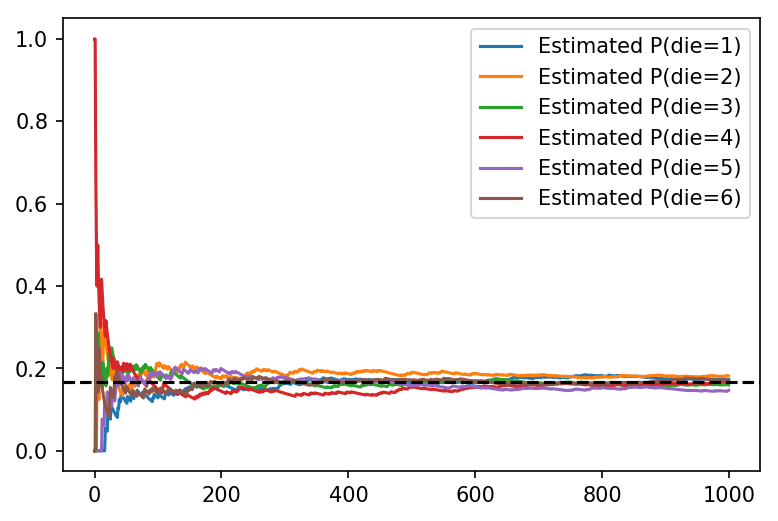

In [8]:
%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
from matplotlib import pyplot as plt

plt.plot(estimates[0,:].asnumpy(), label="Estimated P(die=1)")
plt.plot(estimates[1,:].asnumpy(), label="Estimated P(die=2)")
plt.plot(estimates[2,:].asnumpy(), label="Estimated P(die=3)")
plt.plot(estimates[3,:].asnumpy(), label="Estimated P(die=4)")
plt.plot(estimates[4,:].asnumpy(), label="Estimated P(die=5)")
plt.plot(estimates[5,:].asnumpy(), label="Estimated P(die=6)")
plt.axhline(y=0.1666, color="black", linestyle="dashed")
plt.legend()
plt.show()

## 概率中的一些公理：
 
 There are a few important axioms of probability that you'll want to remember:

* For any event $z$, the probability is never negative, i.e. $\Pr(Z=z) \geq 0$.
* For any two events $Z=z$ and $X=x$ the union is no more likely than the sum of the individual events, i.e. $\Pr(Z=z \cup X=x) \leq \Pr(Z=z) + \Pr(X=x)$.
* For any random variable, the probabilities of all the values it can take must sum to 1 $\sum_{i=1}^n P(Z=z_i) = 1$.
* For any two mutually exclusive events $Z=z$ and $X=x$, the probability that either happens is equal to the sum of their individual probabilities that $\Pr(Z=z \cup X=x) = \Pr(Z=z) + \Pr(X=z)$.

## Naive Bayes Classification

Conditional independence is useful when dealing with data, since it simplifies a lot of equations. 
A popular algorithm is the Naive Bayes Classifier. 
The key assumption in it is that the attributes are all independent of each other, given the labels. 
In other words, we have:

$$p(x|y) = \prod_i p(x_i|y)$$

Using Bayes Theorem this leads to the classifier $p(y|x) = \frac{\prod_i p(x_i|y) p(y)}{p(x)}$. Unfortunately, this is still intractable, since we don't know $p(x)$. Fortunately, we don't need it, since we know that $\sum_y p(y|x) = 1$, hence we can always recover the normalization from $p(y|x) \propto \prod_i p(x_i|y) p(y)$. After all that math, it's time for some code to show how to use a Naive Bayes classifier for distinguishing digits on the MNIST classification dataset. 

The problem is that we don't actually know $p(y)$ and $p(x_i|y)$. So we need to *estimate* it given some training data first. This is what is called *training* the model. In the case of 10 possible classes we simply compute $n_y$, i.e. the number of occurrences of class $y$ and then divide it by the total number of occurrences. E.g. if we have a total of 60,000 pictures of digits and digit 4 occurs 5800 times, we estimate its probability as $\frac{5800}{60000}$. Likewise, to get an idea of $p(x_i|y)$ we count how many times pixel $i$ is set for digit $y$ and then divide it by the number of occurrences of digit $y$. This is the probability that that very pixel will be switched on.

In [9]:
import numpy as np

def transform(data, label):
    return nd.floor(data/128).astype(np.float32), label.astype(np.float32)

mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = mx.gluon.data.vision.MNIST(train=False, transform=transform)

ycount = nd.ones(shape=(10))
xcount = nd.ones(shape=(784, 10))

# 统计训练集中每张图片中每个像素共出现的次数
for data, label in mnist_train:
    x = data.reshape((784,))
    y = int(label)
    ycount[y] += 1
    xcount[:, y] += x
  
# 计算p(x_i|y)
for i in range(10):
    xcount[:, i] = xcount[:, i] / ycount[i]

# 计算p(y)
py = ycount / ycount.sum()

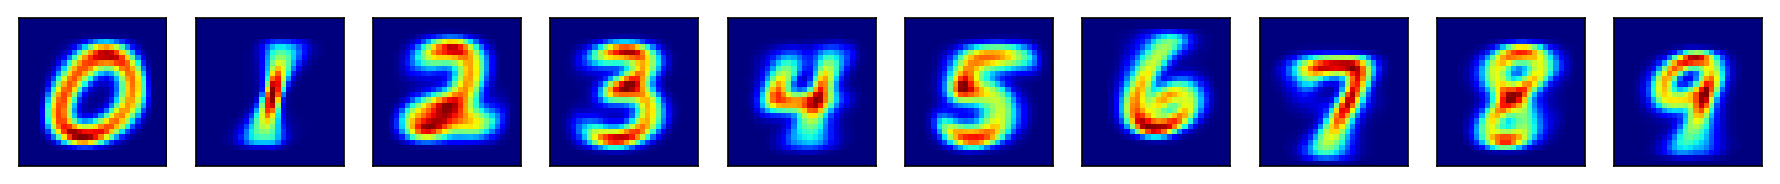

In [10]:
import matplotlib.pyplot as plt
fig, figarr = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    figarr[i].imshow(xcount[:, i].reshape((28, 28)).asnumpy(), cmap="jet")
    figarr[i].axes.get_xaxis().set_visible(False)
    figarr[i].axes.get_yaxis().set_visible(False)    

Now we can compute the likelihoods of an image, given the model. This is statistican speak for $p(x|y)$, i.e. how likely it is to see a particular image under certain conditions (such as the label). Since this is computationally awkward (we might have to multiply many small numbers if many pixels have a small probability of occurring), we are better off computing its logarithm instead. That is, instead of $p(x|y) = \prod_{i} p(x_i|y)$ we compute $\log p(x|y) = \sum_i \log p(x_i|y)$. 

$$l_y := \sum_i \log p(x_i|y) = \sum_i x_i \log p(x_i = 1|y) + (1-x_i) \log \left(1-p(x_i=1|y)\right)$$

To avoid recomputing logarithms all the time, we precompute them for all pixels. 

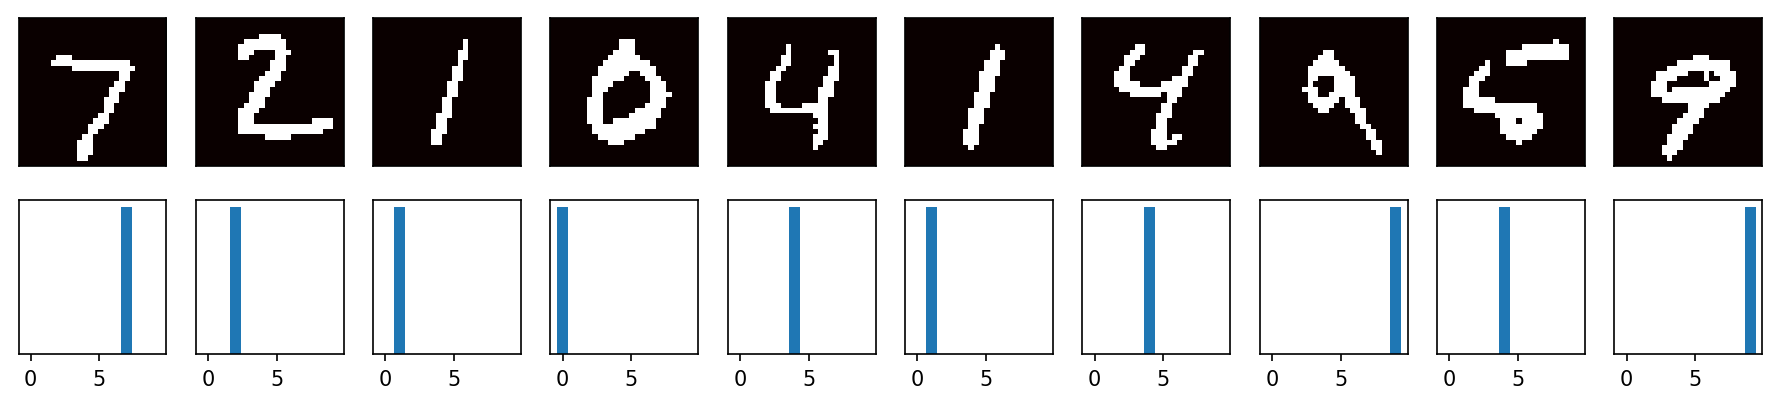

In [11]:
logxcount = nd.log(xcount)
logxcountneg = nd.log(1-xcount)
logpy = nd.log(py)

fig, figarr = plt.subplots(2, 10, figsize=(15, 3))

# 只画十张 用ctr来控制
ctr = 0
for data, label in mnist_test:
    x = data.reshape((784,))
    y = int(label)
    
    # 计算概率
    logpx = logpy.copy()
    for i in range(10):
        # compute the log probability for a digit
        logpx[i] += (nd.dot(logxcount[:, i], x) + nd.dot(logxcountneg[:, i], 1-x))
    # 通过减去最大的概率来正则化防止上溢或下溢
    logpx -= nd.max(logpx)
    # 计算softmax
    px = nd.exp(logpx).asnumpy()
    px /= np.sum(px)
    
    # plot
    figarr[0, ctr].imshow(x.reshape((28,28)).asnumpy(), cmap="hot")    
    figarr[0, ctr].axes.get_xaxis().set_visible(False)
    figarr[0, ctr].axes.get_yaxis().set_visible(False)
    figarr[1, ctr].bar(range(10), px)
    figarr[1, ctr].axes.get_yaxis().set_visible(False)
    ctr += 1
    if ctr==10:
        break

## Uniform distribution

In [12]:
import random

for i in range(10):
    print(random.randint(1,100))

72
27
66
27
23
24
92
93
80
31


其实是说如果大量采样的话，才可以看出其实采样的数字是服从均匀分布的，这一点我们可以从下面的函数看出来

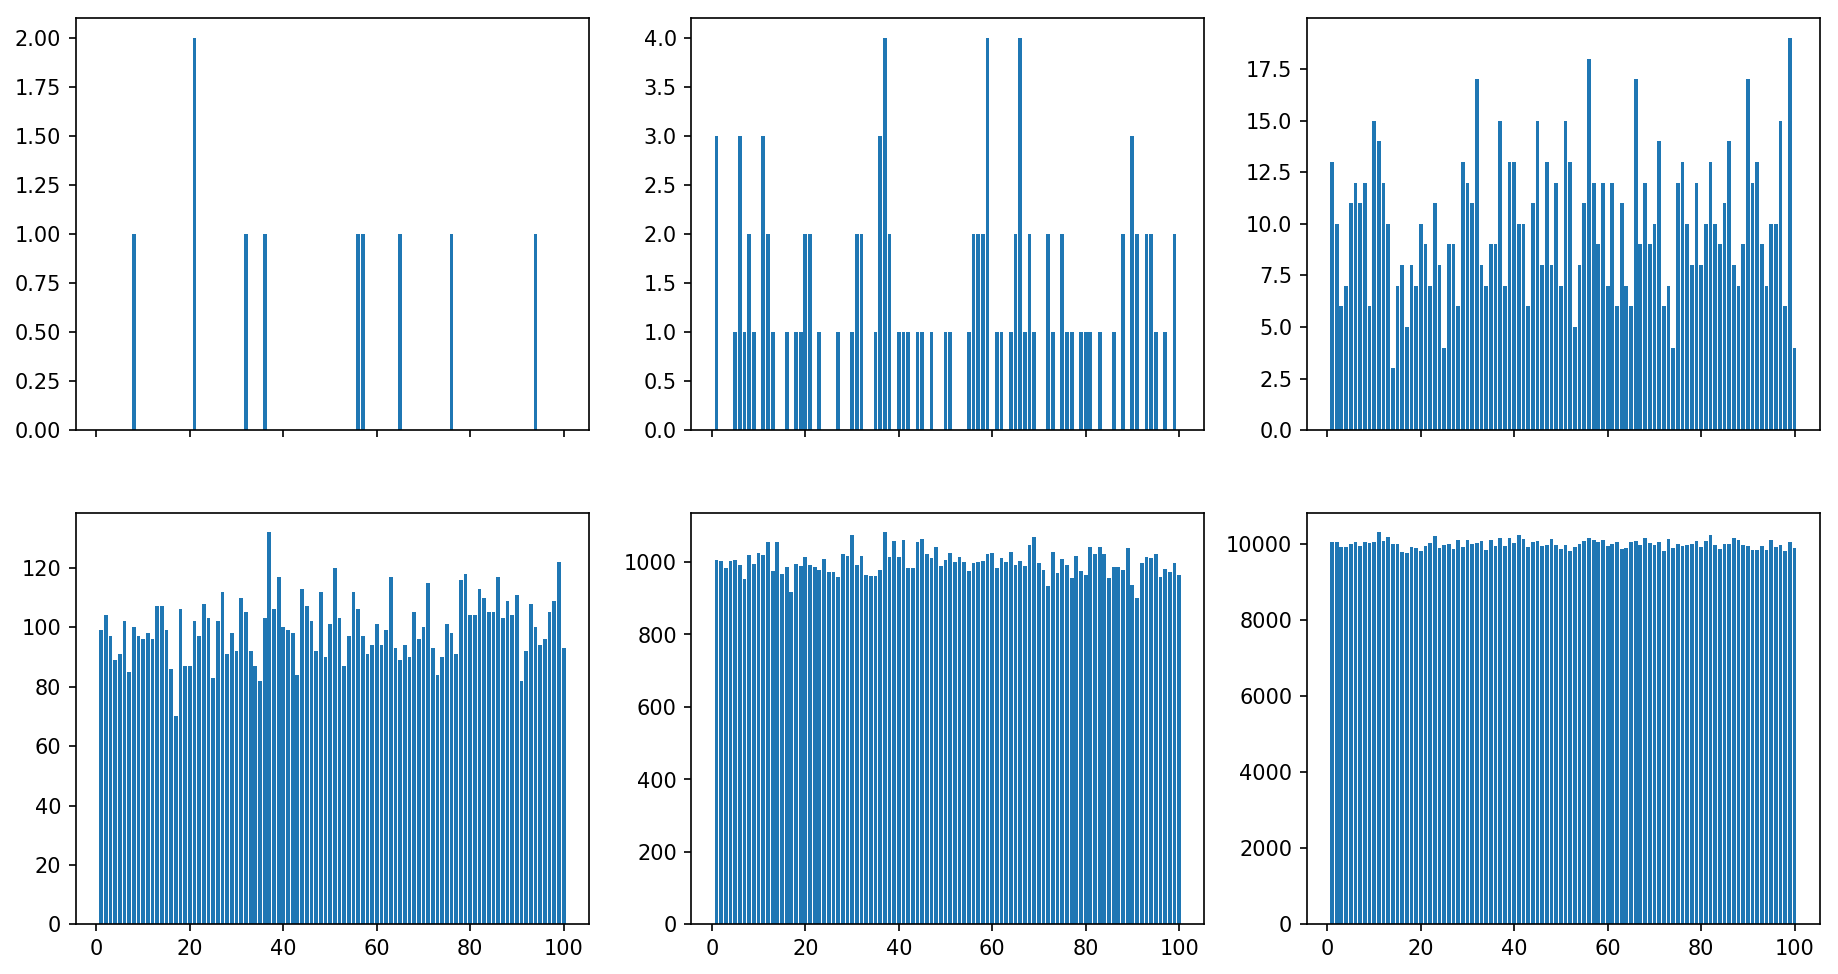

In [13]:
import math

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
axes = axes.reshape(6)

counts = np.zeros(100)
for i in range(1, 1000001):
    counts[random.randint(0,99)] += 1
    if i in [10, 100, 1000, 10000, 100000, 1000000]:
        axes[int(math.log10(i))-1].bar(np.arange(1,101), counts)

## the categorical distribution(没懂？)

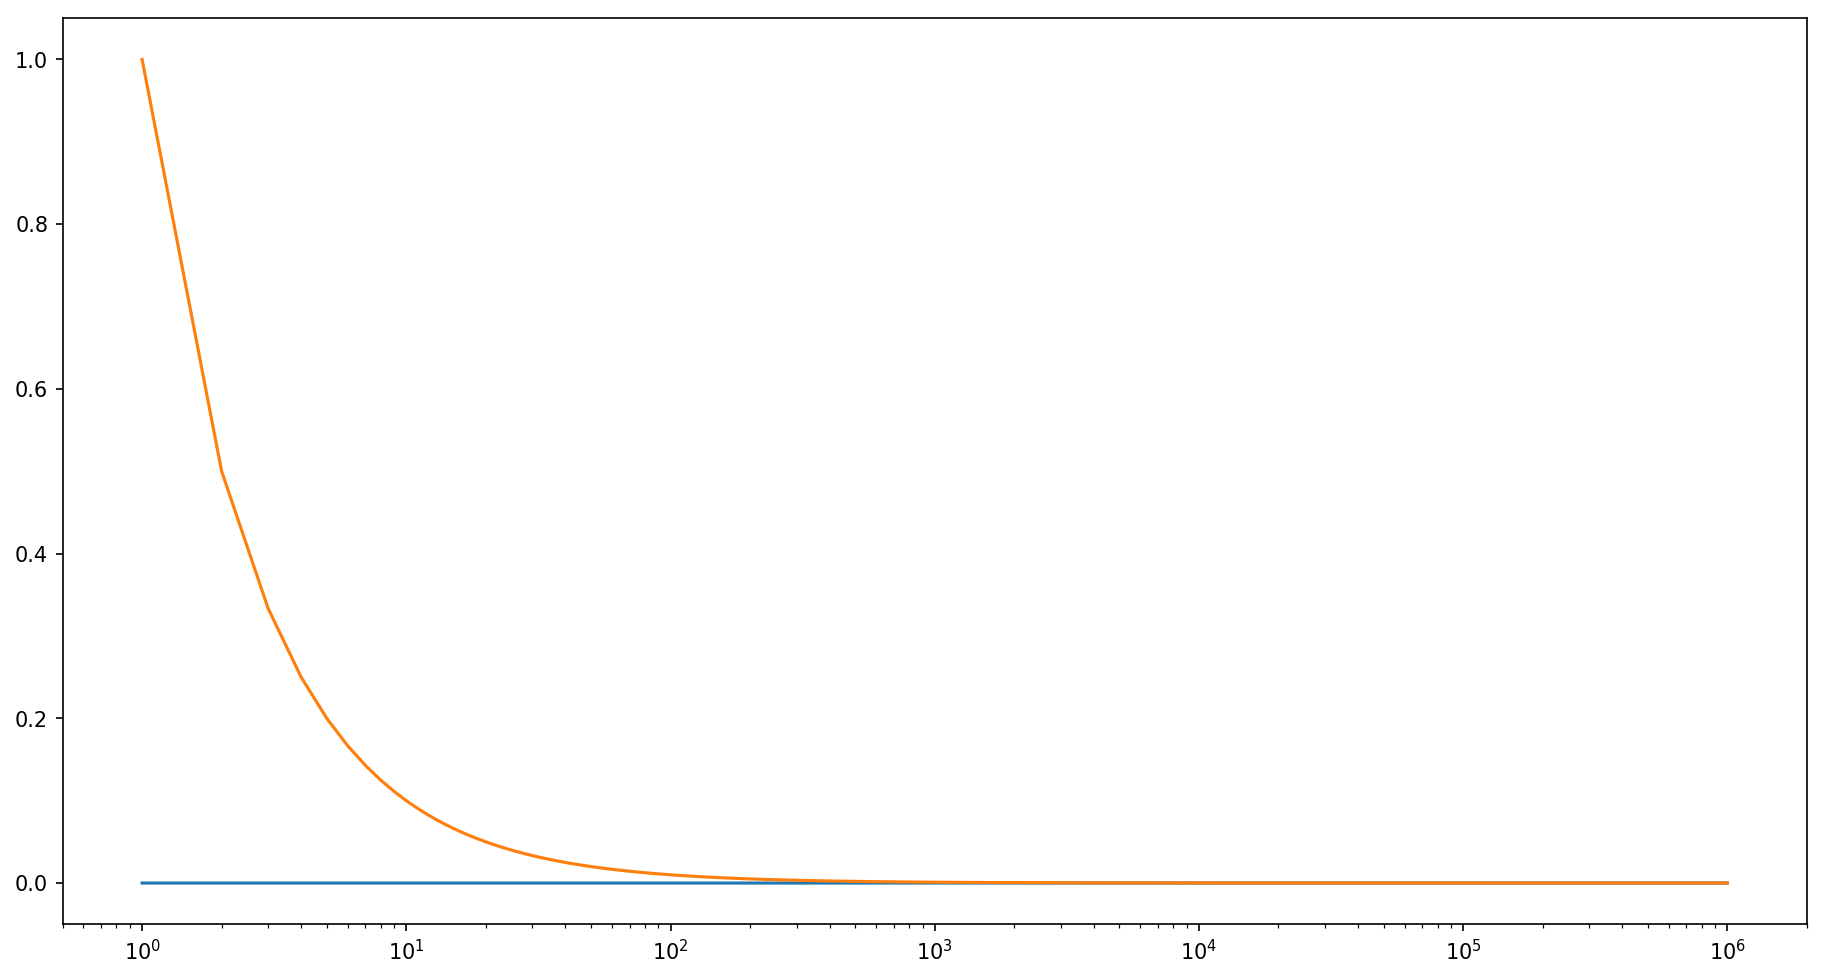

In [14]:
n = 1000000
a = np.random.uniform(0, 1, n)
x = np.arange(1, n+1)
p0 = np.cumsum(y < 0.35) / x
p1 = np.cumsum(y >= 0.35) / x

plt.figure(figsize=(15, 8))
plt.semilogx(x, p0)
plt.semilogx(x, p1)
plt.show()

## Normal distribution

$$\varphi(x) = \frac{1}{\sqrt{2\pi}}exp(-\frac{1}{2}x^2)$$

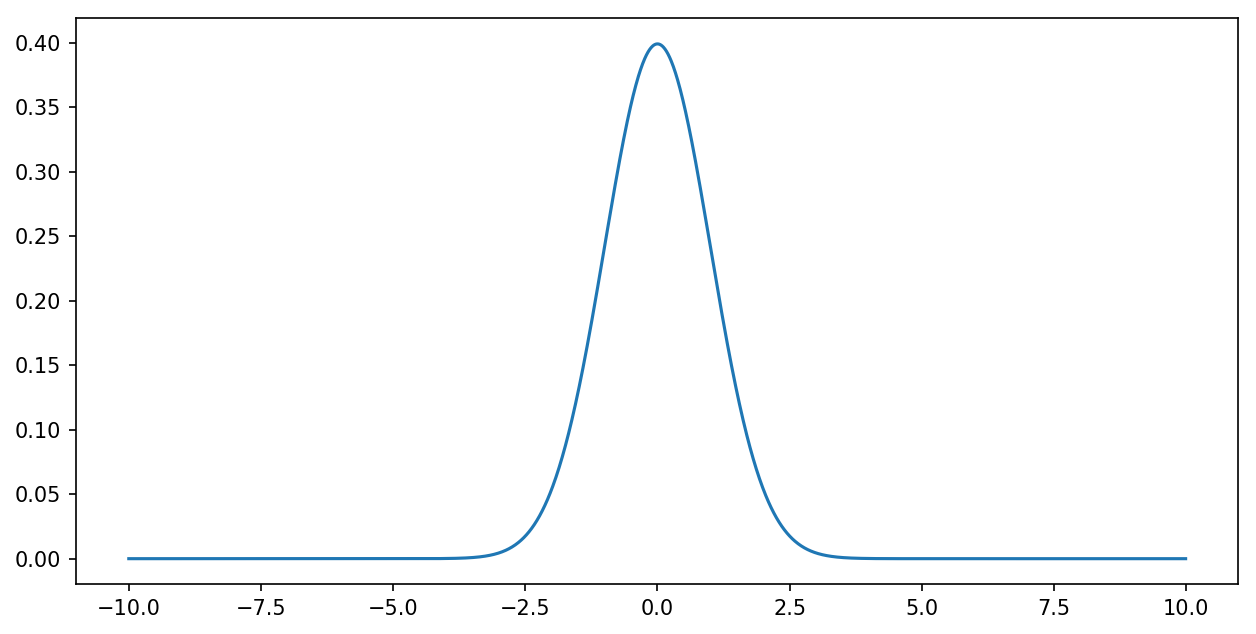

In [15]:
x = np.arange(-10, 10, 0.01)
p = 1 / np.sqrt(2*np.pi) * np.exp(-0.5 * x**2)
plt.figure(figsize=(10, 5))
plt.plot(x, p)
plt.show()

## Central Limit Theorem(中心极限定理)

大量独立随机变量和的分布都服从正态分布

mean 0.9, variance 0.49
(10000, 10)


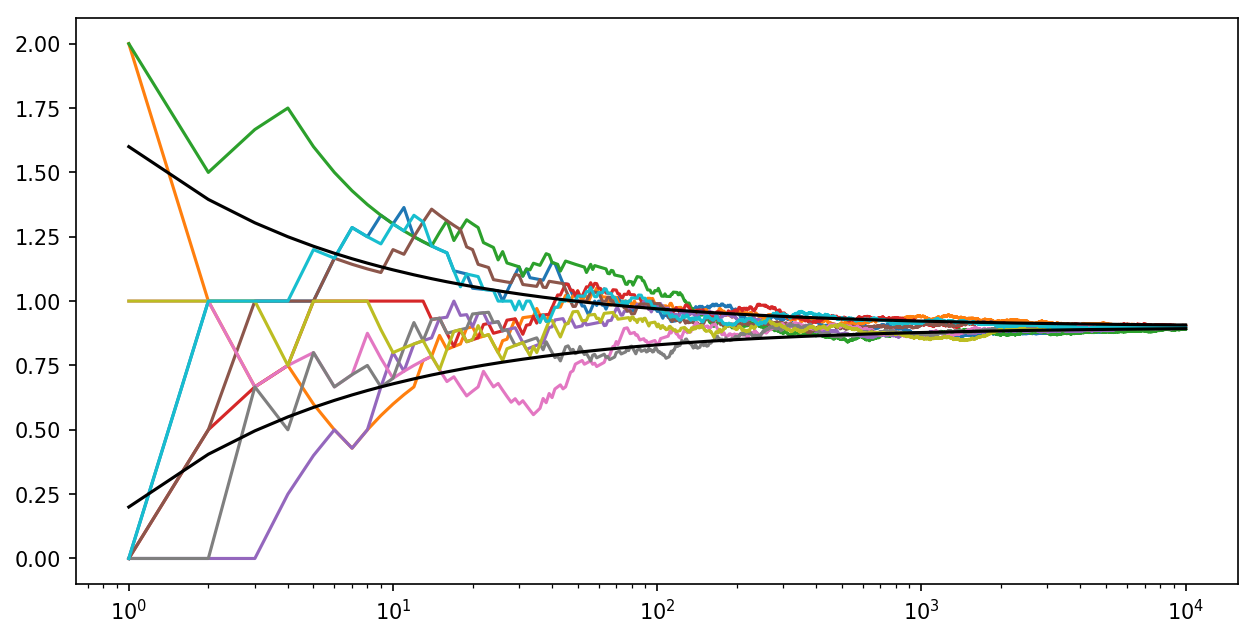

In [29]:
# generate 10 random sequences of 10,000 random normal variables N(0,1)
tmp = np.random.uniform(size=(10000,10))
x = 1.0 * (tmp > 0.3) + 1.0 * (tmp > 0.8)
mean = 1 * 0.5 + 2 * 0.2
variance = 1 * 0.5 + 4 * 0.2 - mean**2
print('mean {}, variance {}'.format(mean, variance))
# cumulative sum and normalization
y = np.arange(1,10001).reshape(10000,1)
z = np.cumsum(x,axis=0) / y

plt.figure(figsize=(10,5))
for i in range(10):
    plt.semilogx(y,z[:,i])

plt.semilogx(y,(variance**0.5) * np.power(y,-0.5) + mean,'black')
plt.semilogx(y,-(variance**0.5) * np.power(y,-0.5) + mean,'black')
plt.show()   